In [11]:
import pandas as pd
from utils import db_connect
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [12]:
# Establecer la conexión a la base de datos
engine = db_connect()

if engine:
    print("Conexión exitosa")

data = pd.read_sql_table('tabla seguro', engine)

pd.set_option('display.max_columns', None)  # muestra todas las columnas del dataframe
data.head()

Conexión exitosa


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [13]:
print(data.shape)
data.info()

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [14]:
data.isnull().any().any()

False

In [15]:
data.duplicated().sum()

1

In [16]:
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

In [17]:
# Usamos pd.factorize para codificar las columnas para preservar el orden de las categorias, 
# a diferencia de LabelEncoder, que usa menos memoria pero no mantiene el orden de las categorias.

# Nos decidimos por esta forma ya que tenemos pocas categorías distintas, y pd.factorize
# devuelve tanto los códigos numéricos como las categorías originales, lo que puede ser útil para futuros análisis.

data["sex_num"] = pd.factorize(data["sex"])[0]
data["smoker_num"] = pd.factorize(data["smoker"])[0]
data["region_num"] = pd.factorize(data["region"])[0]

data.head()


,age,sex,bmi,children,smoker,region,charges,sex_num,smoker_num,region_num
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2


In [18]:
data_num = data[["age", "bmi", "children", "sex_num", "smoker_num", "region_num", "charges"]].copy() # .copy() para crear dataframe independiente al original
data_num.corr()

,age,bmi,children,sex_num,smoker_num,region_num,charges
age,1.000000,0.109344,0.041536,-0.019814,0.025587,-0.001626,0.298308
bmi,0.109344,1.000000,0.012755,0.046397,-0.003746,-0.157574,0.198401
children,0.041536,0.012755,1.000000,0.017848,-0.007331,-0.016258,0.067389
sex_num,-0.019814,0.046397,0.017848,1.000000,-0.076596,-0.004936,0.058044
smoker_num,0.025587,-0.003746,-0.007331,-0.076596,1.000000,-0.002358,-0.787234
region_num,-0.001626,-0.157574,-0.016258,-0.004936,-0.002358,1.000000,0.006547
charges,0.298308,0.198401,0.067389,0.058044,-0.787234,0.006547,1.000000


Edad y Costos: Hay una correlación positiva moderada entre la edad y los costos médicos. Esto sugiere que a medida que la edad aumenta, es probable que los costos médicos también aumenten, lo cual es razonable ya que las personas mayores tienden a tener más problemas de salud y pueden requerir más atención médica.

IMC (BMI) y Costos: Existe una correlación positiva leve entre el índice de masa corporal (IMC) y los costos médicos. Esto indica que las personas con un IMC más alto tienden a tener costos médicos ligeramente más altos. Sin embargo, la correlación no es muy fuerte.

Fumadores y Costos: La correlación entre el hecho de ser fumador y los costos médicos es bastante alta y negativa. Esto sugiere que los fumadores tienden a tener costos médicos mucho más altos en comparación con los no fumadores. Esta es una observación significativa y coherente con la literatura médica, ya que el hábito de fumar está asociado con una variedad de problemas de salud.

Región y Costos: La correlación entre la región y los costos médicos es muy baja, lo que indica que la región donde reside una persona tiene una influencia mínima en sus costos médicos.

Sexo y Costos: La correlación entre el sexo y los costos médicos es muy baja, lo que indica que no hay una relación significativa entre el sexo de una persona y sus costos médicos.

En resumen, la edad, el IMC y el hábito de fumar parecen ser los factores más influyentes en los costos médicos, según esta matriz de correlación.


Vemos que apenas hay correlacion entre la región y la prima de seguro, algo normal, ya que si bien una region puede tener una tendencia hacia una característica influyente mayor que la otra, no tiene que verse reflejada en todos los sujetos de dicha zona, por lo que sería injusto que, por ejemplo, su prima aumentase por proceder de una zona con mayor índice de fumadores, a pesar de que el sujeto concreto no haya fumado en su vida.
Lo mismo ocurre en relación al sexo.

Por tanto, eliminaremos las variables.

In [19]:
data.drop(['region', 'region_num', 'sex', 'sex_num'], axis=1, inplace=True)
data_num.drop(['region_num', 'sex_num'], axis=1, inplace=True)
data_num.head()

,age,bmi,children,smoker_num,charges
0,19,27.900,0,0,16884.92400
1,18,33.770,1,1,1725.55230
2,28,33.000,3,1,4449.46200
3,33,22.705,0,1,21984.47061
4,32,28.880,0,1,3866.85520


Análisis de variables univariantes (categóricas)

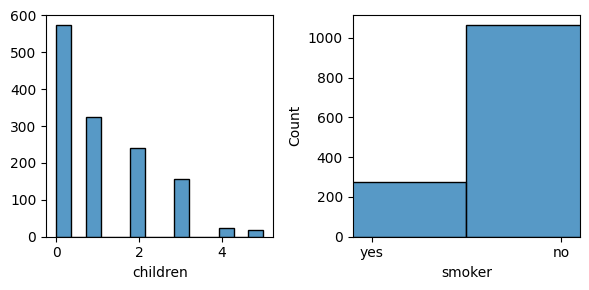

In [22]:
fig, axis = plt.subplots(1, 2, figsize = (6, 3))

sns.histplot(ax = axis[0], data = data, x = "children").set(ylabel = None)
sns.histplot(ax = axis[1], data = data, x = "smoker").set_xlim(-0.1, 1.1)

plt.tight_layout()  # Ajustar el layout

plt.show()

Análisis sobre variables numéricas

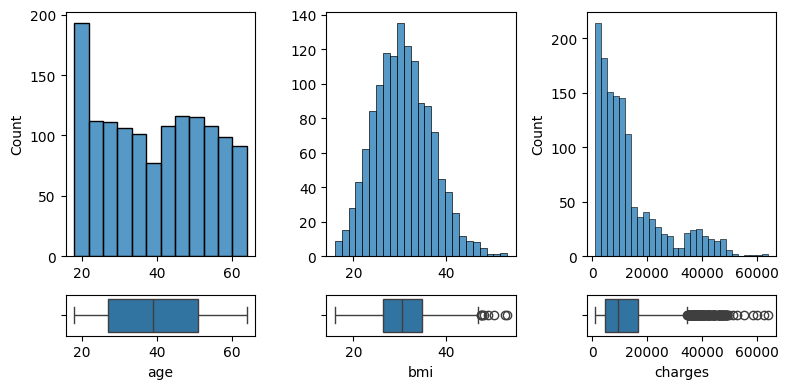

In [25]:
fig, axis = plt.subplots(2, 3, figsize = (8, 4), gridspec_kw={'height_ratios': [6, 1]})

sns.histplot(ax = axis[0, 0], data = data, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "age")

sns.histplot(ax = axis[0, 1], data = data, x = "bmi").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "bmi")

sns.histplot(ax = axis[0, 2], data = data, x = "charges").set(xlabel = None)
sns.boxplot(ax = axis[1, 2], data = data, x = "charges")

plt.tight_layout()

plt.show()